## Analysis of the Quasiparticle Method from an analytical perspective

####  one-body matrix n -> n

Imports

In [2]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

In [3]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


NSM Hamiltonian

In [ ]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
NSMHamiltonian.get_twobody_interaction_optimized(twobody_dict=twobody_matrix)
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)
print(NSMHamiltonian.basis)
print(NSMHamiltonian.hamiltonian)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

Quasiparticle Basis

In [6]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)


(6, 14)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


Get the effective Hamiltonian

In [8]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
print(hamiltonian_qq)

values,psi=eigsh(hamiltonian_qq,k=1)
e0=values[0]

print(values[0])

print(hamiltonian_qq)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 36 stored elements and shape (6, 6)>
  Coords	Values
  (0, 0)	-9.3151
  (0, 1)	0.6897999999999996
  (0, 2)	-0.4062999999999996
  (0, 3)	-0.900781889989654
  (0, 4)	-1.9314456782406446
  (0, 5)	0.6017349640876247
  (1, 0)	0.6897999999999996
  (1, 1)	-8.8615
  (1, 2)	0.8598999999999998
  (1, 3)	0.900781889989654
  (1, 4)	1.1336192497488327
  (1, 5)	-1.3995613925794368
  (2, 0)	-0.4062999999999996
  (2, 1)	0.8598999999999998
  (2, 2)	-9.145
  (2, 3)	-0.900781889989654
  (2, 4)	-0.7347060355029268
  (2, 5)	1.7984746068253425
  (3, 0)	-0.900781889989654
  (3, 1)	0.900781889989654
  (3, 2)	-0.900781889989654
  (3, 3)	-8.107099999999999
  (3, 4)	-0.7177133829043456
  (3, 5)	0.7177133829043456
  (4, 0)	-1.9314456782406446
  (4, 1)	1.1336192497488327
  (4, 2)	-0.7347060355029268
  (4, 3)	-0.7177133829043456
  (4, 4)	3.2251000000000003
  (4, 5)	0.9008999999999998
  (5, 0)	0.6017349640876247
  (5, 1)	-1.3995613925794368
  (5, 2)	1.7984

Build $H_{qq}$ using qubits

In [11]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)

h_qq=0.
for i in range(len(QPC.couples)//2): #just n-n 
    for j in range(len(QPC.couples)//2):
        
        h_qq+=hamiltonian_qq[i,j]*QubitBasis.adag_a_matrix(i,j)
        




one_body_nn={}
matrix=np.zeros((len(QPC.couples)//2,len(QPC.couples)//2))
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_b=np.nonzero(b)[0]
        idx_d=np.nonzero(d)[0]
        matrix[idx_b,idx_d]=hamiltonian_qq[i,j]
        one_body_nn[(idx_b[0],idx_d[0])]=hamiltonian_qq[i,j]
     
keys=np.asarray(list(one_body_nn.keys()))
values=np.asarray(list(one_body_nn.values()))

np.savez('data/matrix_elements_h_eff_2body/one_body_nn_sd',keys=keys,values=values)

6


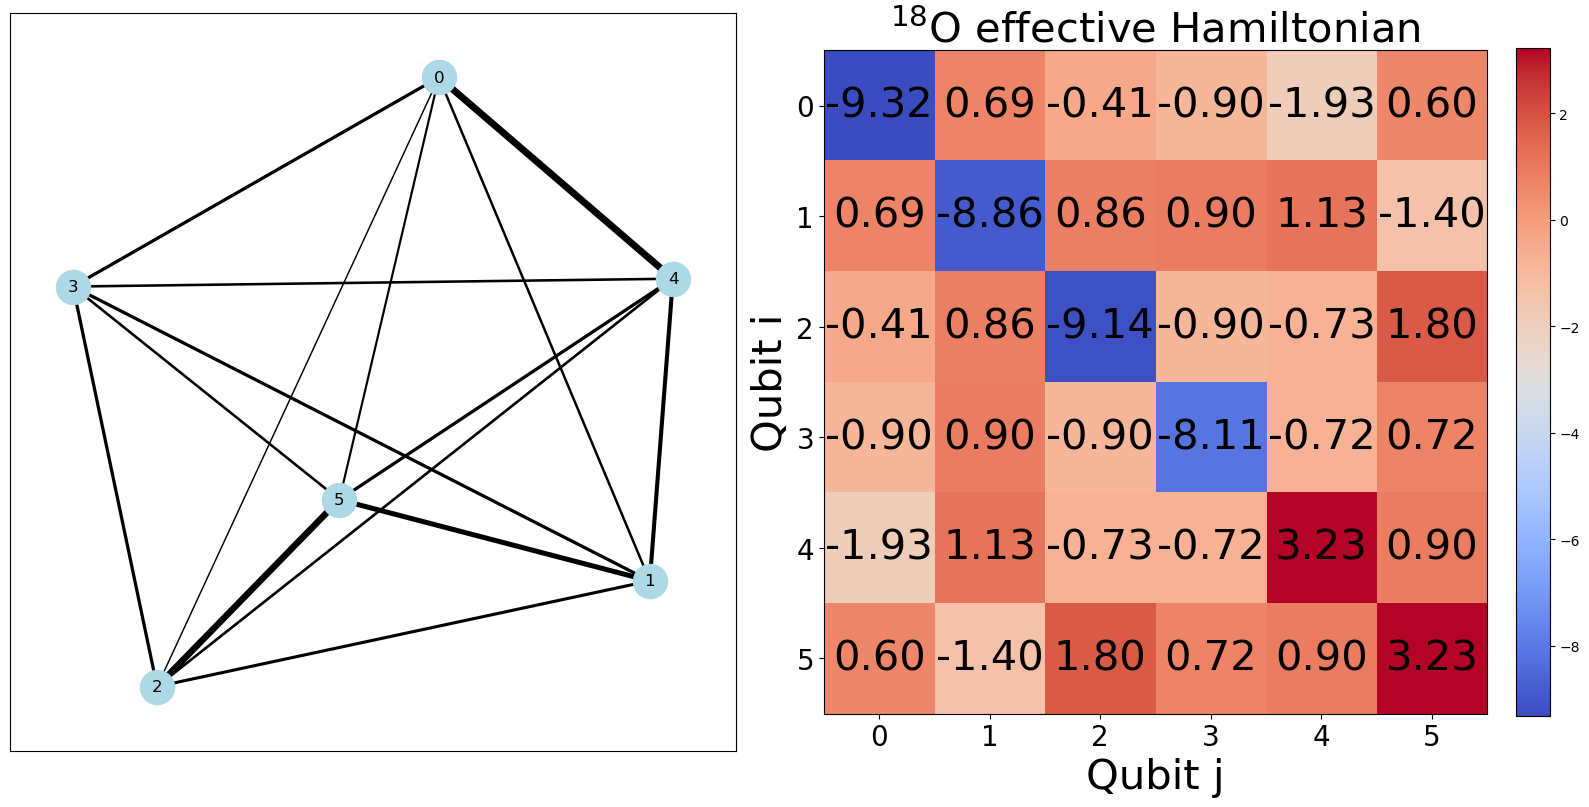

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


# --- Build the graph ---
G = nx.Graph()
n=len(QPC.couples)//2

print(n)
for i in range(n):
    G.add_node(i)
for i in range(n):
    for j in range(i + 1, n):
        weight = abs(matrix[i, j])
        if weight > 1e-8:
            G.add_edge(i, j, weight=weight)

edges = G.edges()
weights = np.array([G[u][v]['weight'] for u, v in edges])
norm_weights = 5 * (weights / weights.max())  # normalized for plotting
pos = nx.spring_layout(G, weight='weight', seed=42)

# --- Create a figure with two subplots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plt.title(r'$^{18}$O effective Hamiltonian',fontsize=30)
# --- Plot the graph ---
ax = axes[0]
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(G, pos, ax=ax, width=norm_weights)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12)

# --- Plot the matrix ---
ax2 = axes[1]
im = ax2.imshow(matrix, cmap='coolwarm')
fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

# Annotate values inside the matrix
for i in range(n):
    for j in range(n):
        value = matrix[i, j]
        ax2.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=30)

ax2.set_xticks(range(n))
ax2.set_yticks(range(n))
ax2.set_xlabel("Qubit j",fontsize=30)
ax2.set_ylabel("Qubit i",fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.show()

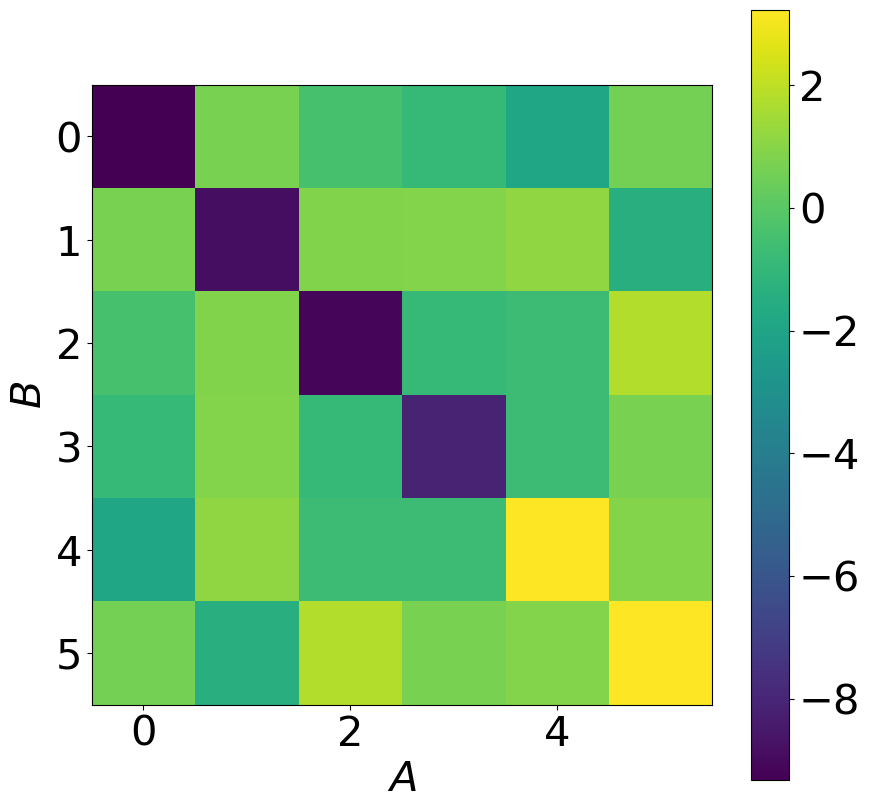

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(matrix[:6,:6])
plt.xlabel(r'$A$',fontsize=30)
plt.ylabel(r'$B$',fontsize=30)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=30)
plt.tick_params(labelsize=30)
plt.show()

####  one-body matrix p -> p

Imports

In [8]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=0
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$Ne'

NSM Hamiltonian

In [9]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)
print(NSMHamiltonian.basis)
print(NSMHamiltonian.hamiltonian)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

size= 24 12
[-11.93178825]
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 180 stored elements and shape (14, 14)>
  Coords	Values
  (0, 0)	-9.3151
  (0, 1)	0.6897999999999995
  (0, 2)	0.20328479938540367
  (0, 3)	-0.4062999999999996
  (0, 4)	-0.5082840208321852
  (0, 5)

Quasiparticle Basis

In [10]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)


(6, 14)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Get the effective Hamiltonian

In [11]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


values,psi=eigsh(hamiltonian_qq,k=1)
e0=values[0]

print(values[0])
values,psi=eigsh(hamiltonian_qq+(1/e0)*hamiltonian_qr @ hamiltonian_rq,k=1)

e1=values[0]

values,psi=eigsh(hamiltonian_qq+(1/e1)*hamiltonian_qr @ hamiltonian_rq+(1/e1**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq,k=1)

e2=values[0]
values,psi=eigsh(hamiltonian_qq+(1/e2)*hamiltonian_qr @ hamiltonian_rq+(1/e2**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq+(1/e2**3)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rr @ hamiltonian_rq,k=1)


print(values[0],np.abs((values[0]-egs[0])/egs[0]))

print(hamiltonian_qq)

-11.93178825156152
-11.931788251561523 4.466279828175239e-16
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 36 stored elements and shape (6, 6)>
  Coords	Values
  (0, 0)	-9.3151
  (0, 1)	0.6897999999999995
  (0, 2)	-0.4062999999999996
  (0, 3)	-0.9007818899896537
  (0, 4)	-1.9314456782406437
  (0, 5)	0.6017349640876244
  (1, 0)	0.6897999999999995
  (1, 1)	-8.8615
  (1, 2)	0.8598999999999996
  (1, 3)	0.9007818899896537
  (1, 4)	1.133619249748832
  (1, 5)	-1.3995613925794361
  (2, 0)	-0.4062999999999996
  (2, 1)	0.8598999999999996
  (2, 2)	-9.145
  (2, 3)	-0.9007818899896537
  (2, 4)	-0.7347060355029265
  (2, 5)	1.7984746068253417
  (3, 0)	-0.9007818899896537
  (3, 1)	0.9007818899896537
  (3, 2)	-0.9007818899896537
  (3, 3)	-8.107099999999999
  (3, 4)	-0.7177133829043454
  (3, 5)	0.7177133829043454
  (4, 0)	-1.9314456782406437
  (4, 1)	1.133619249748832
  (4, 2)	-0.7347060355029265
  (4, 3)	-0.7177133829043454
  (4, 4)	3.2251000000000003
  (4, 5)	0.9008999999999994
  (5, 0

Get the effective coupling

In [12]:
twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
print(twobody_qr)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

print(external_potential_qq)



<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 40 stored elements and shape (6, 8)>
  Coords	Values
  (0, 0)	0.20328479938540367
  (0, 1)	-0.5082840208321852
  (0, 2)	0.1894946496437248
  (0, 3)	0.5082840208321852
  (0, 4)	0.18949464964372487
  (0, 5)	0.20328479938540364
  (0, 6)	0.483679953708077
  (0, 7)	0.483679953708077
  (1, 0)	0.3076369598770807
  (1, 1)	-0.10165680416643712
  (1, 2)	0.6918637014569978
  (1, 3)	0.10165680416643709
  (1, 4)	0.6918637014569978
  (1, 5)	0.3076369598770807
  (1, 6)	0.09673599074161547
  (1, 7)	0.09673599074161547
  (2, 0)	0.10435216049167698
  (2, 1)	0.4066272166657482
  (2, 2)	0.5023690518132727
  (2, 3)	-0.40662721666574814
  (2, 4)	0.5023690518132728
  (2, 5)	0.10435216049167693
  (2, 6)	-0.3869439629664616
  (2, 7)	-0.3869439629664616
  (4, 0)	0.23293633710277387
  (4, 1)	-0.15865
  (4, 2)	-0.09509586140912159
  (4, 3)	0.15864999999999999
  (4, 4)	-0.09509586140912153
  (4, 5)	0.23293633710277392
  (4, 6)	0.17469999999999997
  (4, 

Build $H_{qq}$ using qubits

In [13]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)

h_qq=0.
for i in range(len(QPC.couples)//2): #just n-n 
    for j in range(len(QPC.couples)//2):
        
        h_qq+=hamiltonian_qq[i,j]*QubitBasis.adag_a_matrix(i,j)
        




one_body_pp={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_b=np.nonzero(b)[0]
        idx_d=np.nonzero(d)[0]
        print(idx_d,idx_b)
        one_body_pp[(idx_b[0],idx_d[0])]=hamiltonian_qq[i,j]
        
print(one_body_pp)

keys=np.asarray(list(one_body_pp.keys()))
values=np.asarray(list(one_body_pp.values()))

np.savez('data/matrix_elements_h_eff_2body/one_body_pp_sd',keys=keys,values=values)

[6] [6]
[7] [6]
[8] [6]
[9] [6]
[10] [6]
[11] [6]
[6] [7]
[7] [7]
[8] [7]
[9] [7]
[10] [7]
[11] [7]
[6] [8]
[7] [8]
[8] [8]
[9] [8]
[10] [8]
[11] [8]
[6] [9]
[7] [9]
[8] [9]
[9] [9]
[10] [9]
[11] [9]
[6] [10]
[7] [10]
[8] [10]
[9] [10]
[10] [10]
[11] [10]
[6] [11]
[7] [11]
[8] [11]
[9] [11]
[10] [11]
[11] [11]
{(np.int64(6), np.int64(6)): np.float64(-9.3151), (np.int64(6), np.int64(7)): np.float64(0.6897999999999995), (np.int64(6), np.int64(8)): np.float64(-0.4062999999999996), (np.int64(6), np.int64(9)): np.float64(-0.9007818899896537), (np.int64(6), np.int64(10)): np.float64(-1.9314456782406437), (np.int64(6), np.int64(11)): np.float64(0.6017349640876244), (np.int64(7), np.int64(6)): np.float64(0.6897999999999995), (np.int64(7), np.int64(7)): np.float64(-8.8615), (np.int64(7), np.int64(8)): np.float64(0.8598999999999996), (np.int64(7), np.int64(9)): np.float64(0.9007818899896537), (np.int64(7), np.int64(10)): np.float64(1.133619249748832), (np.int64(7), np.int64(11)): np.float64(-1.3

#### Proton-Neutron Case

Imports

In [14]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

#### p-n -> p-n quasiparticle interaction

In [23]:

file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0ne20=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0ne20,basis=NSMHamiltonian.basis))

print(NSMHamiltonian.hamiltonian.shape)

size= 24 12
[-41.39649007]
total_m= [1.03202494e-17]
(640, 640)


Quasiparticle Basis

In [ ]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
for b in QPC.quasiparticle_basis:
    if np.sum(b)!=2:
        print(np.sum(b),'\n')

print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)


rest_basis_ne20=QPC.rest_basis.copy()
quasiparticle_basis_ne20=QPC.quasiparticle_basis.copy()



(36, 12)
(604, 24)


Get the effective Hamiltonian

In [18]:
twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
print(twobody_qq)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

print(external_potential_qq)

  (np.int32(0), np.int32(0))	-14.51434603174604
  (np.int32(0), np.int32(1))	0.6897999999999995
  (np.int32(0), np.int32(2))	-0.4062999999999996
  (np.int32(0), np.int32(3))	-0.9007818899896537
  (np.int32(0), np.int32(4))	-1.9314456782406437
  (np.int32(0), np.int32(5))	0.6017349640876244
  (np.int32(0), np.int32(6))	0.6897999999999996
  (np.int32(0), np.int32(12))	-0.4062999999999996
  (np.int32(0), np.int32(18))	-0.900781889989654
  (np.int32(0), np.int32(24))	-1.9314456782406446
  (np.int32(0), np.int32(30))	0.6017349640876247
  (np.int32(1), np.int32(0))	0.6897999999999995
  (np.int32(1), np.int32(1))	-9.485076190476194
  (np.int32(1), np.int32(2))	0.8598999999999996
  (np.int32(1), np.int32(3))	0.9007818899896537
  (np.int32(1), np.int32(4))	1.133619249748832
  (np.int32(1), np.int32(5))	-1.3995613925794361
  (np.int32(1), np.int32(7))	0.6897999999999996
  (np.int32(1), np.int32(13))	-0.4062999999999996
  (np.int32(1), np.int32(19))	-0.900781889989654
  (np.int32(1), np.int32(25)

In [27]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
#print(twobody_qr)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
h_qq=0.

for key,value in one_body_nn.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
for key,value in one_body_pp.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
#### twobody terms
twobody_nnpp={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        if hamiltonian_qq[i,j]-h_qq[i,j]!=0.:
            twobody_nnpp[(idx_a,idx_b,idx_c,idx_d)]=hamiltonian_qq[i,j]-h_qq[i,j]


keys=np.asarray(list(twobody_nnpp.keys()))
values=np.asarray(list(twobody_nnpp.values()))
print(keys)
np.savez('data/matrix_elements_h_eff_2body/twobody_np_sd',keys=keys,values=values)


h_qq=0.

for key,value in one_body_nn.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
for key,value in one_body_pp.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
    
for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

h_qq_only_twobody=0.
for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq_only_twobody+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

value,_=eigsh(h_qq,k=1)

print(value)

value,_=eigsh(h_qq,k=1)

print('only two body=',value)

print('norm ham_rr=',scipy.sparse.linalg.norm(hamiltonian_rr))
value,_=eigsh(hamiltonian_rr,k=1)
print(values[0])
print(hamiltonian_rr.shape)

hamiltonian_ne20_qq=hamiltonian_qq.copy()


eng,_=eigsh(hamiltonian_ne20_qq,k=1,which='SA')

print(eng)

[[ 0  6  0  6]
 [ 0  7  0  7]
 [ 0  8  0  8]
 [ 0  9  0  9]
 [ 0 10  0 10]
 [ 0 11  0 11]
 [ 1  6  1  6]
 [ 1  7  1  7]
 [ 1  8  1  8]
 [ 1  9  1  9]
 [ 1 10  1 10]
 [ 1 11  1 11]
 [ 2  6  2  6]
 [ 2  7  2  7]
 [ 2  8  2  8]
 [ 2  9  2  9]
 [ 2 10  2 10]
 [ 2 11  2 11]
 [ 3  6  3  6]
 [ 3  7  3  7]
 [ 3  8  3  8]
 [ 3  9  3  9]
 [ 3 10  3 10]
 [ 3 11  3 11]
 [ 4  6  4  6]
 [ 4  7  4  7]
 [ 4  8  4  8]
 [ 4  9  4  9]
 [ 4 10  4 10]
 [ 4 11  4 11]
 [ 5  6  5  6]
 [ 5  7  5  7]
 [ 5  8  5  8]
 [ 5  9  5  9]
 [ 5 10  5 10]
 [ 5 11  5 11]]
[-32.20884586]
only two body= [-32.20884586]
norm ham_rr= 396.6653601215977
-11.586946031746042
(604, 604)
[-32.20884586]


In [20]:
nsteps_iteration=20
single_term = hamiltonian_rq  # Start with initial term
approximations=[]
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result
    
    
tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

100%|██████████| 30/30 [00:00<00:00, 319.07it/s]

-32.20884586000003
0.2219425897331771 index= 0
-34.31925991676875
0.17096208261605042 index= 1
-36.12155194839487
0.12742476753289686 index= 2
-37.45880480565934
0.09512123515804558 index= 3
-38.417450708991765
0.0719635736835613 index= 4
-39.1132412738953
0.055155613306152984 index= 5
-39.625178733841565
0.042788925718659034 index= 6
-40.00833174513005
0.03353323735916769 index= 7
-40.29889065311416
0.02651431117787205 index= 8
-40.52226146513023
0.021118423467960123 index= 9
-40.69565638978871
0.016929785147307527 index= 10
-40.83170395421678
0.013643333465303312 index= 11
-40.939147469801526
0.01104785941916088 index= 12
-41.024763330381134
0.008979668120103408 index= 13
-41.09322482182353
0.007325868695988399 index= 14
-41.14844489107944
0.005991937506191719 index= 15
-41.19297671445531
0.0049161983964796764 index= 16
-41.22927235909482
0.00403941767000067 index= 17
-41.25867331179455
0.003329189516642978 index= 18
-41.28289905482998
0.002743977026575314 index= 19
-41.3024988677464

In [21]:
print(delta_hamiltonian)

  (np.int32(0), np.int32(35))	-0.04538065209837642
  (np.int32(0), np.int32(33))	0.06754584844076456
  (np.int32(0), np.int32(32))	0.1359778187015913
  (np.int32(0), np.int32(30))	0.3579299960059192
  (np.int32(0), np.int32(28))	-0.46800655929179436
  (np.int32(0), np.int32(25))	0.4203599652860635
  (np.int32(0), np.int32(24))	-1.0640894890885166
  (np.int32(0), np.int32(23))	0.06754584844076461
  (np.int32(0), np.int32(21))	-0.37430962216291735
  (np.int32(0), np.int32(20))	-0.1585247761613239
  (np.int32(0), np.int32(18))	-0.9205205546023337
  (np.int32(0), np.int32(17))	0.13597781870159137
  (np.int32(0), np.int32(5))	0.35792999600591924
  (np.int32(0), np.int32(15))	-0.1585247761613239
  (np.int32(0), np.int32(3))	-0.9205205546023337
  (np.int32(0), np.int32(14))	-0.024958414651874105
  (np.int32(0), np.int32(12))	-0.6170599013658644
  (np.int32(0), np.int32(2))	-0.6170599013658647
  (np.int32(0), np.int32(10))	0.42035996528606373
  (np.int32(0), np.int32(4))	-1.0640894890885169
  

Get the effective (p-p)--(n-n) interaction

In [28]:




tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
off_diagonal_hamiltonians_rr=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
rq_correction=hamiltonian_rq.copy()
qr_correction=hamiltonian_qr.copy()
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result
    


two_body_corrections=[]
for operator in approximations:
    twobody_term={}
    for i,b in enumerate(QPC.quasiparticle_basis):
        for j,d in enumerate(QPC.quasiparticle_basis):
            idx_a,idx_b=np.nonzero(b)[0]
            idx_c,idx_d=np.nonzero(d)[0]
            
            twobody_term[(idx_a,idx_b,idx_c,idx_d)]=operator[i,j]#-external_potential_qq[i,j]
    two_body_corrections.append(twobody_term)


# mean_field_hamiltonian=[]
# twoparticle_virtual_process_basis=QPC.rest_basis.copy()
# mean_field_hamiltonian=lil_matrix((twoparticle_virtual_process_basis.shape[0],twoparticle_virtual_process_basis.shape[0]))
# for i,b in enumerate(twoparticle_virtual_process_basis):
#     idx_a,idx_b,idx_c,idx_d=np.nonzero(b)[0]
    
#     count=0
#     for j,d in enumerate(QPC.rest_basis):
#         jdx_a,jdx_b,jdx_c,jdx_d=np.nonzero(d)[0]
#         if np.isclose(d[idx_a]*d[idx_b]*d[idx_c]*d[idx_d],1.):

#             mean_field_hamiltonian[i,i]+=hamiltonian_rr[j,j]
#             count+=1
        
#     mean_field_hamiltonian[i,i]=mean_field_hamiltonian[i,i]/count

# print(mean_field_hamiltonian)
# print('difference=',hamiltonian_rr-off_diagonal_hamiltonians_rr-mean_field_hamiltonian)

#### using this mean field algorithm



100%|██████████| 30/30 [00:00<00:00, 148.12it/s]


In [23]:

twobody_term_last_correction={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        
        twobody_term_last_correction[(idx_a,idx_b,idx_c,idx_d)]=delta_hamiltonian[i,j]#-external_potential_qq[i,j]


keys=np.asarray(list(twobody_term_last_correction.keys()))
values=np.asarray(list(twobody_term_last_correction.values()))

np.savez('data/matrix_elements_h_eff_2body/twobody_np_correction_sd',keys=keys,values=values)

In [24]:
print(twobody_term_last_correction)

{(np.int64(0), np.int64(6), np.int64(0), np.int64(6)): np.float64(-1.670609512440261), (np.int64(0), np.int64(6), np.int64(0), np.int64(7)): np.float64(0.5360416726468711), (np.int64(0), np.int64(6), np.int64(0), np.int64(8)): np.float64(-0.6170599013658647), (np.int64(0), np.int64(6), np.int64(0), np.int64(9)): np.float64(-0.9205205546023337), (np.int64(0), np.int64(6), np.int64(0), np.int64(10)): np.float64(-1.0640894890885169), (np.int64(0), np.int64(6), np.int64(0), np.int64(11)): np.float64(0.35792999600591924), (np.int64(0), np.int64(6), np.int64(1), np.int64(6)): np.float64(0.5360416726468711), (np.int64(0), np.int64(6), np.int64(1), np.int64(7)): np.float64(-0.10115127429183826), (np.int64(0), np.int64(6), np.int64(1), np.int64(8)): np.float64(0.05170325131985357), (np.int64(0), np.int64(6), np.int64(1), np.int64(9)): np.float64(0.1289081030567667), (np.int64(0), np.int64(6), np.int64(1), np.int64(10)): np.float64(0.42035996528606373), (np.int64(0), np.int64(6), np.int64(1), np

#### n-n -> n-n quasiparticle interaction

In [29]:
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=4
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

size= 24 12
[-23.93429271]
total_m= [0.]


Pairing Hamiltonian one-body term

In [30]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)

print(QPC.rest_basis.shape)
print(QPC.couples)
print(QPC.rest_basis)

external_potential_qubit=np.zeros(len(QPC.couples))

external_potential_qubit=2*SPS.energies


(15, 81)
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]
(66, 24)
[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]
[[1 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##### Two-body correction

In [31]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
#print(twobody_qr)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
h_qq=0.

for key,value in one_body_pp.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
for key,value in one_body_nn.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

#### twobody terms
twobody_nn={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        if hamiltonian_qq[i,j]-h_qq[i,j]!=0.:
            twobody_nn[(idx_a,idx_b,idx_c,idx_d)]=hamiltonian_qq[i,j]-h_qq[i,j]
            

keys=np.asarray(list(twobody_nn.keys()))
values=np.asarray(list(twobody_nn.values()))

np.savez('data/matrix_elements_h_eff_2body/twobody_nn_sd',keys=keys,values=values)
 

h_qq=0.

for key,value in one_body_nn.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
for key,value in one_body_pp.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)


for key,value in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

value,_=eigsh(h_qq,k=1)
print(h_qq)
print(value)

<List of Lists sparse matrix of dtype 'float64'
	with 135 stored elements and shape (15, 15)>
  Coords	Values
  (0, 0)	-20.1382
  (0, 1)	0.8598999999999998
  (0, 2)	0.900781889989654
  (0, 3)	1.1336192497488327
  (0, 4)	-1.3995613925794368
  (0, 5)	-0.4062999999999996
  (0, 6)	-0.900781889989654
  (0, 7)	-1.9314456782406446
  (0, 8)	0.6017349640876247
  (1, 0)	0.8598999999999998
  (1, 1)	-19.8547
  (1, 2)	-0.900781889989654
  (1, 3)	-0.7347060355029268
  (1, 4)	1.7984746068253425
  (1, 5)	0.6897999999999996
  (1, 9)	-0.900781889989654
  (1, 10)	-1.9314456782406446
  (1, 11)	0.6017349640876247
  (2, 0)	0.900781889989654
  (2, 1)	-0.900781889989654
  (2, 2)	-17.39346666666667
  (2, 3)	-0.7177133829043456
  (2, 4)	0.7177133829043456
  (2, 6)	0.6897999999999996
  (2, 9)	-0.4062999999999996
  :	:
  (12, 6)	1.1336192497488327
  (12, 7)	0.900781889989654
  (12, 9)	-0.7347060355029268
  (12, 10)	-0.900781889989654
  (12, 12)	-4.8668
  (12, 13)	0.9008999999999998
  (12, 14)	0.7177133829043456
 

Correction for the (n-n)--(p-p) interaction

In [32]:




tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result





 
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

100%|██████████| 30/30 [00:00<00:00, 418.41it/s]

-23.424939176438897
0.021281327927613163 index= 0
-23.66057338500437
0.01143628209996011 index= 1
-23.77644033770558
0.006595238576617116 index= 2
-23.841536193772967
0.003875465034077069 index= 3
-23.879346892002808
0.002295694171796223 index= 4
-23.90157577891148
0.001366947825304783 index= 5
-23.91473800316114
0.0008170162100242188 index= 6
-23.92257230362808
0.0004896908713385591 index= 7
-23.92725351712551
0.0002941048327416595 index= 8
-23.93005873320523
0.00017689994543167463 index= 9
-23.931743299694084
0.00010651698031183068 index= 10
-23.932756446133816
6.418665319164121e-05 index= 11
-23.933366450878246
3.8700011415107126e-05 index= 12
-23.933734017976484
2.334267026792799e-05 index= 13
-23.933955626163637
1.4083646412290144e-05 index= 14
-23.93408928931873
8.499058778028952e-06 index= 15
-23.934169932062495
5.1297198655563725e-06 index= 16
-23.93421859650959
3.0964679249538163e-06 index= 17
-23.93424796804172
1.8692943256705294e-06 index= 18
-23.934265697372272
1.1285441908

In [33]:
print(delta_hamiltonian)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 225 stored elements and shape (15, 15)>
  Coords	Values
  (0, 14)	-0.11044578233017822
  (0, 13)	-0.09703833099878781
  (0, 12)	0.00839810191196954
  (0, 8)	0.012525753551546896
  (0, 6)	-0.041237816816442716
  (0, 11)	-0.059859821865014776
  (0, 9)	0.09891429955621539
  (0, 2)	-0.10543034878526912
  (0, 10)	0.0065708355134266585
  (0, 5)	0.3264940500023024
  (0, 7)	0.12257037487568177
  (0, 4)	0.04684572058315921
  (0, 3)	0.22587705692222695
  (0, 1)	0.0880124864135682
  (0, 0)	-0.7602749950724668
  (1, 13)	0.06112120922833408
  (1, 14)	0.05293381231617429
  (1, 12)	-0.04264487777056223
  (1, 8)	-0.07420319173850372
  (1, 6)	0.009033772840155507
  (1, 11)	0.03953712675080531
  (1, 9)	-0.036657091938620316
  (1, 2)	0.011995443915855056
  (1, 10)	0.10256620849720481
  (1, 5)	-0.06641776216757096
  :	:
  (13, 14)	0.014288675875783472
  (13, 12)	-0.015799791094401567
  (13, 3)	-0.03943775508142752
  (13, 1)	0.06112120922833407


In [34]:

twobody_term_corrections_nn={}
#twobody_term_corrections_pp={}

for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]

        twobody_term_corrections_nn[(idx_a,idx_b,idx_c,idx_d)]=delta_hamiltonian[i,j]#-external_potential_qq[i,j]
        #twobody_term_corrections_pp[(idx_a+len(QPC.couples)//2,idx_b+len(QPC.couples)//2,idx_c+len(QPC.couples)//2,idx_d+len(QPC.couples)//2)]=delta_hamiltonian[i,j]


keys=np.asarray(list(twobody_term_corrections_nn.keys()))
values=np.asarray(list(twobody_term_corrections_nn.values()))

np.savez('data/matrix_elements_h_eff_2body/twobody_nn_correction_sd',keys=keys,values=values)

print(twobody_term_corrections_nn)

{(np.int64(0), np.int64(1), np.int64(0), np.int64(1)): np.float64(-0.7602749950724668), (np.int64(0), np.int64(1), np.int64(0), np.int64(2)): np.float64(0.0880124864135682), (np.int64(0), np.int64(1), np.int64(0), np.int64(3)): np.float64(-0.10543034878526912), (np.int64(0), np.int64(1), np.int64(0), np.int64(4)): np.float64(0.22587705692222695), (np.int64(0), np.int64(1), np.int64(0), np.int64(5)): np.float64(0.04684572058315921), (np.int64(0), np.int64(1), np.int64(1), np.int64(2)): np.float64(0.3264940500023024), (np.int64(0), np.int64(1), np.int64(1), np.int64(3)): np.float64(-0.041237816816442716), (np.int64(0), np.int64(1), np.int64(1), np.int64(4)): np.float64(0.12257037487568177), (np.int64(0), np.int64(1), np.int64(1), np.int64(5)): np.float64(0.012525753551546896), (np.int64(0), np.int64(1), np.int64(2), np.int64(3)): np.float64(0.09891429955621539), (np.int64(0), np.int64(1), np.int64(2), np.int64(4)): np.float64(0.0065708355134266585), (np.int64(0), np.int64(1), np.int64(2)

#### p-p -> p-p quasiparticle interaction

In [35]:
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=0
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Mg'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)
print(NSMHamiltonian.hamiltonian)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

size= 24 12
[-23.93429271]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2757 stored elements and shape (81, 81)>
  Coords	Values
  (0, 0)	-20.1382
  (0, 1)	0.8239782407375151
  (0, 2)	0.8598999999999996
  (0, 3)	0.40391911635242017
  (0, 4)	0.10165680416643712
  (0, 5)	-0.6918637014569978
  (0, 6)	-0.4546230489830741
  (0, 7)	0.4237229179758751
  (0, 8)	-0.10165680416643709
  (0, 9)	-0.6918637014569978
  (0, 12)	0.8239782407375158
  (0, 13)	-0.3746568811211513
  (0, 14)	-0.6489247535071269
  (0, 15)	1.0299894902376425
  (0, 16)	0.9007818899896537
  (0, 17)	0.09673599074161547
  (0, 18)	0.09673599074161547
  (0, 19)	1.133619249748832
  (0, 20)	-1.3995613925794361
  (0, 22)	-0.4062999999999996
  (0, 24)	0.5082840208321852
  (0, 25)	-0.1894946496437248
  (0, 26)	0.4546230489830743
  (0, 27)	0.42372291797587514
  (0, 30)	-0.5082840208321852
  :	:
  (80, 45)	0.1295371825641837
  (80, 46)	0.25907436512836757
  (80, 47)	-2.636779683484747e-16
  (80, 52)	1.7984746068253417
  (

Pairing Hamiltonian one-body term

In [36]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)

print(QPC.rest_basis.shape)
print(QPC.couples)
print(QPC.rest_basis)




(15, 81)
[[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
(66, 24)
[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]]


##### Two-body correction

In [37]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
#print(twobody_qr)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
h_qq=0.

for key,value in one_body_nn.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
for key,value in one_body_pp.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

#### twobody terms
twobody_pp={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        if hamiltonian_qq[i,j]-h_qq[i,j]!=0.:
            twobody_pp[(idx_a,idx_b,idx_c,idx_d)]=hamiltonian_qq[i,j]-h_qq[i,j]
            

keys=np.asarray(list(twobody_pp.keys()))
values=np.asarray(list(twobody_pp.values()))

np.savez('data/matrix_elements_h_eff_2body/twobody_pp_sd',keys=keys,values=values)
 

h_qq=0.

for key,value in one_body_nn.items():
    idx_a,idx_b=key
    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

for key,value in one_body_pp.items():
    idx_a,idx_b=key
    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)


for key,value in twobody_pp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

value,_=eigsh(h_qq,k=1)

print(value)

[-23.42493918]


Correction for the (p-p)--(p-p) interaction

In [38]:




tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result





 
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

100%|██████████| 30/30 [00:00<00:00, 205.35it/s]

-23.424939176438897
0.021281327927613745 index= 0
-23.660573385004383
0.011436282099960103 index= 1
-23.77644033770558
0.006595238576617706 index= 2
-23.84153619377298
0.003875465034077067 index= 3
-23.879346892002808
0.0022956941717968155 index= 4
-23.901575778911493
0.001366947825304782 index= 5
-23.914738003161126
0.0008170162100254058 index= 6
-23.922572303628073
0.0004896908713394495 index= 7
-23.927253517125507
0.0002941048327424015 index= 8
-23.930058733205243
0.00017689994543167452 index= 9
-23.931743299694073
0.00010651698031286967 index= 10
-23.93275644613382
6.418665319208648e-05 index= 11
-23.933366450878246
3.870001141570085e-05 index= 12
-23.93373401797649
2.334267026822485e-05 index= 13
-23.933955626163616
1.4083646413774496e-05 index= 14
-23.934089289318734
8.499058778474256e-06 index= 15
-23.934169932062492
5.12971986629855e-06 index= 16
-23.934218596509595
3.096467925399123e-06 index= 17
-23.934247968041724
1.8692943261158366e-06 index= 18
-23.93426569737227
1.1285441

In [39]:
print(delta_hamiltonian)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 225 stored elements and shape (15, 15)>
  Coords	Values
  (0, 14)	-0.1104457823301782
  (0, 13)	-0.09703833099878782
  (0, 12)	0.008398101911969528
  (0, 8)	0.012525753551546824
  (0, 6)	-0.04123781681644275
  (0, 11)	-0.05985982186501475
  (0, 9)	0.09891429955621543
  (0, 2)	-0.10543034878526919
  (0, 10)	0.006570835513426627
  (0, 5)	0.3264940500023029
  (0, 7)	0.12257037487568177
  (0, 4)	0.04684572058315917
  (0, 3)	0.2258770569222271
  (0, 1)	0.08801248641356821
  (0, 0)	-0.7602749950724669
  (1, 13)	0.06112120922833407
  (1, 14)	0.052933812316174285
  (1, 12)	-0.0426448777705622
  (1, 8)	-0.07420319173850369
  (1, 6)	0.009033772840155526
  (1, 11)	0.039537126750805306
  (1, 9)	-0.03665709193862037
  (1, 2)	0.011995443915855108
  (1, 10)	0.1025662084972048
  (1, 5)	-0.06641776216757105
  :	:
  (13, 14)	0.01428867587578346
  (13, 12)	-0.015799791094401577
  (13, 3)	-0.03943775508142753
  (13, 1)	0.06112120922833408
  (13

In [40]:

twobody_term_corrections_pp={}

for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]

        twobody_term_corrections_pp[(idx_a,idx_b,idx_c,idx_d)]=delta_hamiltonian[i,j]#-external_potential_qq[i,j]



keys=np.asarray(list(twobody_term_corrections_pp.keys()))
values=np.asarray(list(twobody_term_corrections_pp.values()))

np.savez('data/matrix_elements_h_eff_2body/twobody_pp_correction_sd',keys=keys,values=values)
print(twobody_term_corrections_pp)

{(np.int64(6), np.int64(7), np.int64(6), np.int64(7)): np.float64(-0.7602749950724669), (np.int64(6), np.int64(7), np.int64(6), np.int64(8)): np.float64(0.08801248641356821), (np.int64(6), np.int64(7), np.int64(6), np.int64(9)): np.float64(-0.10543034878526919), (np.int64(6), np.int64(7), np.int64(6), np.int64(10)): np.float64(0.2258770569222271), (np.int64(6), np.int64(7), np.int64(6), np.int64(11)): np.float64(0.04684572058315917), (np.int64(6), np.int64(7), np.int64(7), np.int64(8)): np.float64(0.3264940500023029), (np.int64(6), np.int64(7), np.int64(7), np.int64(9)): np.float64(-0.04123781681644275), (np.int64(6), np.int64(7), np.int64(7), np.int64(10)): np.float64(0.12257037487568177), (np.int64(6), np.int64(7), np.int64(7), np.int64(11)): np.float64(0.012525753551546824), (np.int64(6), np.int64(7), np.int64(8), np.int64(9)): np.float64(0.09891429955621543), (np.int64(6), np.int64(7), np.int64(8), np.int64(10)): np.float64(0.006570835513426627), (np.int64(6), np.int64(7), np.int64

#### The $^{24}$ Mg case

In [41]:
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=4
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{28}$Si'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis)) 
        
        
        



size= 24 12
[-92.77520307]
total_m= [1.8355204e-18]


#### Get the mean Field coefficients

In [42]:
one_particle_density=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    one_particle_density[i]=psi0.conjugate().T.dot(NSMHamiltonian.adag_a_matrix(i,i).dot(psi0))

/tmp/ipykernel_1124010/3556869370.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  one_particle_density[i]=psi0.conjugate().T.dot(NSMHamiltonian.adag_a_matrix(i,i).dot(psi0))


KeyboardInterrupt: 

In [24]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [01:11<00:00,  2.97s/it]


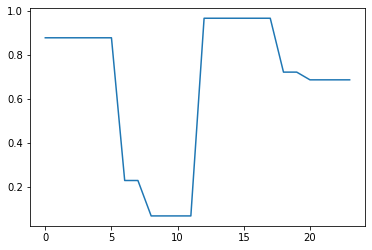

15.999999999999988


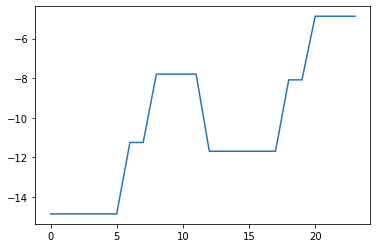

-178.63965857589278


In [165]:
plt.plot(one_particle_density)
plt.show()
print(np.sum(one_particle_density))

energy_values_meanfield=np.zeros((size_a+size_b))
for a in range(size_a+size_b):
    energy_values_meanfield[a]=SPS.energies[a]
    for b in range(size_a+size_b):
        if (a,b,a,b) in twobody_matrix.keys():
            energy_values_meanfield[a]+=twobody_matrix[(a,b,a,b)]*one_particle_density[b]/2

plt.plot(energy_values_meanfield)
plt.show()
        
print(np.sum(energy_values_meanfield*one_particle_density))


In [166]:
MeanFieldHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
MeanFieldHamiltonian.get_external_potential(external_potential=energy_values_meanfield)
#MeanFieldHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a-2}_{nparticles_b-2}.npz')
MeanFieldHamiltonian.get_hamiltonian()

egs,psi0=MeanFieldHamiltonian.get_spectrum(n_states=1)

print(egs)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=MeanFieldHamiltonian.basis)) 

size= 24 12
[-185.31551383]
total_m= [1.4012557e-45]


In [167]:
print(energy_values_meanfield)

[-14.87012213 -14.87012213 -14.87012213 -14.87012213 -14.87012213
 -14.87012213 -11.25356287 -11.25356287  -7.79600063  -7.79600063
  -7.79600063  -7.79600063 -11.69847079 -11.69847079 -11.69847079
 -11.69847079 -11.69847079 -11.69847079  -8.08563548  -8.08563548
  -4.86634268  -4.86634268  -4.86634268  -4.86634268]


In [168]:
print(MeanFieldHamiltonian.hamiltonian)
print(MeanFieldHamiltonian.basis[0])

  (0, 0)	-185.31551383374617
  (1, 1)	-185.31551383374617
  (2, 2)	-182.09622103362238
  (3, 3)	-182.09622103362238
  (4, 4)	-178.8769282334986
  (5, 5)	-178.48338572577288
  (6, 6)	-178.48338572577285
  (7, 7)	-175.26409292564907
  (8, 8)	-178.48338572577285
  (9, 9)	-175.26409292564907
  (10, 10)	-171.65125761779953
  (11, 11)	-178.48338572577285
  (12, 12)	-171.65125761779956
  (13, 13)	-171.6512576177996
  (14, 14)	-174.8668264733636
  (15, 15)	-174.8668264733636
  (16, 16)	-171.64753367323982
  (17, 17)	-168.03469836539028
  (18, 18)	-181.6989545813369
  (19, 19)	-178.4796617812131
  (20, 20)	-174.8668264733636
  (21, 21)	-174.8668264733636
  (22, 22)	-171.64753367323982
  (23, 23)	-168.03469836539028
  (24, 24)	-174.8668264733636
  :	:
  (7537, 7537)	-146.57034049961254
  (7538, 7538)	-143.35104769948876
  (7539, 7539)	-146.57034049961254
  (7540, 7540)	-143.35104769948876
  (7541, 7541)	-146.57034049961254
  (7542, 7542)	-139.73821239163925
  (7543, 7543)	-139.73821239163925
  (

#### Effective H_rr

In [169]:
from itertools import combinations
# you have to conserve the m valueeeee
def find_lowest_energy_subset(energy_values, m_values, sorted_indices):
    for size in range(2, len(sorted_indices) + 1, 2):  # Only even sizes (to make sum=0 possible)
        for subset in combinations(sorted_indices, size):  # Iterate over all subsets
            if np.sum(m_values[list(subset)]) == 0:  # Check if sum(m) == 0
                return np.array(subset)  # Return the first valid subset
    return np.array([])  # Return empty if no subset found

m_values=np.array([-5/2,-3/2,-1/2,1/2,3/2,5/2,-1/2,1/2,-3/2,-1/2,1/2,3/2,-5/2,-3/2,-1/2,1/2,3/2,5/2,-1/2,1/2,-3/2,-1/2,1/2,3/2])


mean_field_hamiltonian_rr=lil_matrix((rest_basis_ne20.shape[0],rest_basis_ne20.shape[0]))
basis_restricted=np.zeros_like(rest_basis_ne20)
elements=[]

for i,basis in enumerate(rest_basis_ne20):
    
    a,b,c,d=np.nonzero(basis)[0]


    comb_neutrons=combinations(QPC.couples[:size_a//2],(nparticles_a-2)//2)
    comb_protons=combinations(QPC.couples[size_a//2:],(nparticles_b-2)//2)
    
    
    min=0
    for set_neutron_couples in comb_neutrons:
        
        neutron_sets=[]
        for couple in set_neutron_couples:

            x,y=couple
            neutron_sets.append(x)
            neutron_sets.append(y)
        
        if a in neutron_sets or b in neutron_sets:
            continue

        for set_proton_couples in comb_protons:
            
            
            
            proton_sets=[]
            for couple in set_proton_couples:
                x,y=couple
                proton_sets.append(x)
                proton_sets.append(y)

            if c in proton_sets or d in proton_sets:
                continue
            

               

            
            if np.sum(m_values[[(proton_sets)]])+np.sum(m_values[[a,b,c,d]])+np.sum(m_values[[(neutron_sets)]])==0. :
                e_neutron=np.sum(energy_values_meanfield[[neutron_sets]])
                e_proton=np.sum(energy_values_meanfield[[proton_sets]])
                
                e_total=e_neutron+e_proton
                if e_total < min:
                    new_base=np.zeros((size_a+size_b))
                    min=e_total
                    if len(proton_sets)!=0:
                        new_base[[proton_sets]]=1
                    if len(neutron_sets)!=0:
                        new_base[[neutron_sets]]=1
                    new_base[[a,b,c,d]]=1
            else:
                continue
                    
    if min!=0:
        basis_restricted[i]=(new_base)

    

    

    energy_included=np.sum(energy_values_meanfield[[a,b]])+np.sum(energy_values_meanfield[[c,d]]) 
    energy_excluded= min

    if min!=0.:
        mean_field_hamiltonian_rr[i,i]=energy_excluded+energy_included



# dressed_qr_hamiltonian=lil_matrix((hamiltonian_ne20_qq.shape[0],rest_basis_ne20.shape[0]))
# qr_correction_dictionary=qr_correction.tocoo()
# for q,r,value in zip(qr_correction_dictionary.row,qr_correction_dictionary.col,qr_correction_dictionary.data):
#     basis=rest_basis_ne20[r]
#     i,j,k,l=np.nonzero(basis)[0]
#     min_values_sorted=np.sort(np.setdiff1d(energy_values_meanfield,[i,j,k,l]))
#     energy_excluded= np.sum(min_values_sorted[:4])
#     dressed_qr_hamiltonian[q,r]=qr_correction[q,r]+energy_excluded

# dressed_rq_hamiltonian=lil_matrix((rest_basis_ne20.shape[0],hamiltonian_ne20_qq.shape[0]))
# rq_correction_dictionary=rq_correction.tocoo()
# for r,q,value in zip(rq_correction_dictionary.row,rq_correction_dictionary.col,rq_correction_dictionary.data):
#     basis=rest_basis_ne20[r]
#     i,j,k,l=np.nonzero(basis)[0]
#     min_values_sorted=np.sort(np.setdiff1d(energy_values_meanfield,[i,j,k,l]))
#     energy_excluded= np.sum(min_values_sorted[:4])
#     dressed_rq_hamiltonian[r,q]=rq_correction[r,q]+energy_excluded    
    




/tmp/ipykernel_577035/1729250186.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(m_values[[(proton_sets)]])+np.sum(m_values[[a,b,c,d]])+np.sum(m_values[[(neutron_sets)]])==0. :
/tmp/ipykernel_577035/1729250186.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e_neutron=np.sum(energy_values_meanfield[[neutron_sets]])
/tmp/ipykernel_577035/1729250186.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpret

We need to correct the H_rq and H_qr

In [170]:
print(mean_field_hamiltonian_rr)

  (0, 0)	-164.41813911298098
  (1, 1)	-171.2502672209543
  (2, 2)	-164.41813911298098
  (3, 3)	-171.25026722095427
  (4, 4)	-168.0309744208305
  (5, 5)	-171.25026722095424
  (6, 6)	-164.41813911298098
  (7, 7)	-164.41813911298095
  (8, 8)	-171.25026722095424
  (9, 9)	-168.0309744208305
  (10, 10)	-171.25026722095427
  (11, 11)	-168.0309744208305
  (12, 12)	-171.25026722095424
  (13, 13)	-174.8631025288038
  (14, 14)	-178.08239532892756
  (15, 15)	-164.418139112981
  (16, 16)	-164.41813911298098
  (17, 17)	-171.25026722095427
  (18, 18)	-168.0309744208305
  (19, 19)	-171.25026722095427
  (20, 20)	-168.0309744208305
  (21, 21)	-171.2502672209543
  (22, 22)	-171.2502672209543
  (23, 23)	-174.86310252880384
  (24, 24)	-174.8631025288038
  (25, 25)	-178.0823953289276
  (26, 26)	-178.48338572577285
  (27, 27)	-175.26409292564904
  (28, 28)	-178.48338572577282
  (29, 29)	-175.26409292564904
  (30, 30)	-178.48338572577282
  (31, 31)	-178.48338572577285
  (32, 32)	-182.09622103362236
  (33, 33)

In [25]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)



In [172]:
#print(mean_field_hamiltonian_rr)


converted_quasiparticle_basis=np.zeros((QPC.quasiparticle_basis.shape[0],2*QPC.quasiparticle_basis.shape[1]))
for i,b in enumerate(QPC.quasiparticle_basis):
    index=np.nonzero(b)[0]
    new_base=np.zeros(2*QPC.quasiparticle_basis.shape[1])
    for idxs in index:
        new_base[QPC.couples[idxs]]=1
    converted_quasiparticle_basis[i]=new_base


In [173]:
dictionary_qr_correction=qr_correction.tocoo()
dictionary_qr_correction = {(row, col): value for row, col, value in zip(dictionary_qr_correction.row, dictionary_qr_correction.col, dictionary_qr_correction.data)}
print(QPC.couples)
effective_qr=lil_matrix((qr_correction.shape[0],qr_correction.shape[1]))
print(qr_correction.shape)
counter={}
for b in converted_quasiparticle_basis:
    counter[tuple(b)]=0.
print(counter)

for key,value in dictionary_qr_correction.items():
    a,i=key

        #print('keys=',key)
        
    x,y,z,w=np.nonzero(rest_basis_ne20[i])[0]
    new_item=basis_restricted[i].copy()

    new_item[[x,y,z,w]]=0.

    
    quasiparticle_indices=np.nonzero(quasiparticle_basis_ne20[a])[0]

    # for index in quasiparticle_indices:
    #     #print('couples=',QPC.couples[index])
    #     new_item[QPC.couples[index]]+=1
    #     print(np.sum(new_item),np.nonzero(new_item)[0],'with couple',QPC.couples[index])
    # # print('new indices=',new_item,'\n')
    # # print('sum=',np.sum(new_item))
    # if tuple(new_item) in counter.keys():
    #     # print('MARIO')
    #     # print(np.nonzero(new_item)[0],'\n')
        
    #     print(converted_quasiparticle_basis[a],'\n')
    #     print(basis_restricted[i],'\n')
    #     #if counter[tuple(new_item)]<=1:
    #     effective_qr[a,i]=value
    #     counter[tuple(new_item)]+=1
    # #print(new_item,converted_quasiparticle_basis[a])
    # else:
    #     print(key,'is not accepted \n')
            
    effective_qr[a,i]=value


# dictionary_rq_correction=rq_correction.tocoo()
# dictionary_rq_correction = {(row, col): value for row, col, value in zip(dictionary_rq_correction.row, dictionary_rq_correction.col, dictionary_rq_correction.data)}
# print(QPC.couples)
# effective_rq=lil_matrix((rq_correction.shape[0],rq_correction.shape[1]))
# for key,value in dictionary_rq_correction.items():
#     i,a=key
#     x,y,z,w=np.nonzero(rest_basis_ne20[i])[0]
#     new_item=basis_restricted[i].copy()
#     new_item[[x,y,z,w]]=0.
    
#     quasiparticle_indices=np.nonzero(quasiparticle_basis_ne20[a])[0]
#     for index in quasiparticle_indices:

#         new_item[QPC.couples[index]]+=1
#     if new_item in converted_quasiparticle_basis:
#         # print('MARIO')
#         # print(np.nonzero(new_item)[0],'\n')
#         effective_rq[i,a]=value
#     #print(new_item,converted_quasiparticle_basis[a])
#     else:
#         print(key,'is not accepted \n')  

    

[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]
(36, 604)
{(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 

In [174]:
print(counter)
print(np.sum(list(counter.values())))

{(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,

In [175]:
count_connections=0
for a in range(qr_correction.shape[0]):
    for i in range(qr_correction.shape[1]):
        if a==1 and qr_correction[a,i]!=0.:
            count_connections+=1

In [176]:
print(count_connections)
print(hamiltonian_qr)
print(hamiltonian_qr.shape)

for i in range(7):
    print(QPC.quasiparticle_basis[0])
    print(QPC.quasiparticle_basis[i],'\n')

60
  (0, 0)	-1.1102230246251565e-16
  (0, 1)	-1.27675647831893e-15
  (0, 2)	-1.8318679906315083e-15
  (0, 3)	-0.7108614512386662
  (0, 4)	0.977133826556014
  (0, 5)	1.609823385706477e-15
  (0, 6)	4.718447854656915e-16
  (0, 7)	0.5298448425179364
  (0, 8)	-0.7283125530979124
  (0, 9)	0.23695381707955535
  (0, 10)	0.410416050229172
  (0, 11)	-0.6514225510373428
  (0, 12)	-0.3869439629664616
  (0, 13)	-0.3869439629664616
  (0, 19)	4.85722573273506e-16
  (0, 20)	-0.3746568811211513
  (0, 21)	-0.6489247535071269
  (0, 22)	1.0299894902376425
  (0, 23)	0.09673599074161547
  (0, 24)	0.09673599074161547
  (0, 26)	0.410416050229172
  (0, 27)	0.23695381707955537
  (0, 28)	-0.6514225510373428
  (0, 38)	-0.7108614512386662
  (0, 39)	0.977133826556014
  :	:
  (399, 93270)	0.977133826556014
  (399, 93271)	0.7108614512386662
  (399, 93281)	-0.6514225510373428
  (399, 93282)	-0.23695381707955537
  (399, 93283)	-0.410416050229172
  (399, 93285)	-0.09673599074161547
  (399, 93286)	-0.09673599074161547
  

In [177]:
print(qr_correction)

  (0, 0)	-0.45876507936507965
  (0, 1)	1.096283198521862
  (0, 2)	0.11816984126984101
  (0, 4)	-0.027423351397426327
  (0, 5)	-0.44278468996383347
  (0, 6)	-0.2881301587301583
  (0, 11)	0.4808606694347589
  (0, 12)	0.6322793396075583
  (0, 15)	0.23103492063492015
  (0, 22)	-0.8929983991364584
  (0, 26)	0.20328479938540367
  (0, 27)	-0.5082840208321852
  (0, 28)	0.1894946496437248
  (0, 29)	0.5082840208321852
  (0, 30)	0.18949464964372487
  (0, 31)	0.20328479938540364
  (0, 32)	0.483679953708077
  (0, 33)	0.483679953708077
  (0, 34)	0.027423351397426327
  (0, 36)	-0.2245657281313674
  (0, 37)	0.23371242231056472
  (0, 38)	-0.4808606694347589
  (0, 43)	0.6762161618582865
  (0, 44)	0.2499675313975125
  (0, 47)	1.0962831985218615
  :	:
  (35, 534)	-0.11179270703329697
  (35, 536)	0.3837438166376979
  (35, 538)	-0.32893247559339583
  (35, 552)	-0.4744024744405058
  (35, 554)	0.21613933262539406
  (35, 556)	-0.64662
  (35, 561)	0.5061955498269921
  (35, 563)	-0.2414661373377319
  (35, 566)	-

In [178]:
print(effective_qr.shape,QPC.quasiparticle_basis.shape[0])
for i in range(quasiparticle_basis_ne20.shape[0]):
    for j in range(quasiparticle_basis_ne20.shape[0]):
        print((effective_qr @ effective_qr.T)[i,j],i,j)

(36, 604) 120
22.250253882563612 0 0
-5.025788110465884 0 1
3.8834760421294137 0 2
5.505936580591535 0 3
14.059724361739434 0 4
-4.093170625774788 0 5
-5.025788110465886 0 6
0.527685065195263 0 7
0.0 0 8
0.0 0 9
-3.9985659844432035 0 10
0.0 0 11
3.8834760421294128 0 12
0.0 0 13
0.19396619951121147 0 14
0.46395804722222245 0 15
0.0 0 16
-1.1916708899218762 0 17
5.505936580591536 0 18
0.0 0 19
0.46395804722222245 0 20
1.015396127619047 0 21
0.0 0 22
-0.23421052619047628 0 23
14.05972436173943 0 24
-3.998565984443199 0 25
0.0 0 26
0.0 0 27
6.075247869208319 0 28
0.0 0 29
-4.093170625774788 0 30
0.0 0 31
-1.1916708899218755 0 32
-0.23421052619047628 0 33
0.0 0 34
0.3830202240456472 0 35
-5.025788110465884 1 0
26.041858506780386 1 1
-1.3538070115793654 1 2
-1.2545371078034688 1 3
-7.754701850430439 1 4
-0.05724458350705776 1 5
8.898971797188217 1 6
-1.239488045165389 1 7
0.010431571882086333 1 8
0.7399263469095827 1 9
0.0 1 10
-0.023355460225575105 1 11
0.0 1 12
0.7131681897491131 1 13
-0.1

In [ ]:
# for i in range(quasiparticle_basis_ne20.shape[0]):
#     for j in range(quasiparticle_basis_ne20.shape[0]):
#         print((qr_correction @ rq_correction)[i,j],i,j)
print(hamiltonian_qr.shape)
for i in range(QPC.quasiparticle_basis.shape[0]):
    for j in range(QPC.quasiparticle_basis.shape[0]):
        print((hamiltonian_qr @ hamiltonian_rq)[i,j],i,j)

(400, 93310)
62.06484601000005 0 0
4.82602374704741 0 1
4.61050982079444 0 2
-6.388547386431676 0 3
-4.826023747047411 0 4
-4.826058422308022 0 5
5.270567813717329 0 6
-1.122942228571428 0 7
0.18715703809523793 0 8
2.758283709999996 0 9
4.826023747047409 0 10
6.881531373496555 0 11
-4.6589844164500125 0 12
0.5614711142857144 0 13
-0.748628152380952 0 14
-1.06087835 0 15
-0.28073555714285714 0 16
1.0293637095238095 0 17
2.121756699999999 0 18
0.0 0 19
4.826023747047408 0 20
0.9664389801904756 0 21
0.00014268342857142827 0 22


-0.14978376076190475 0 23
-0.13055239314285727 0 24
-0.2846362766542761 0 25
0.08048905391715225 0 26
0.0 0 27
0.0 0 28
0.0 0 29
0.0 0 30
0.1403677785714287 0 31
0.0 0 32
0.0 0 33
0.0 0 34
0.0 0 35
0.0 0 36
0.0 0 37
0.0 0 38
0.0 0 39
4.610509820794438 0 40
0.00014268342857142827 0 41
0.5518312629848141 0 42
-0.07222982628231656 0 43
-0.27708849706000926 0 44
0.0 0 45
1.9490531071304897 0 46
0.0 0 47
0.0 0 48
0.0 0 49
0.1403677785714287 0 50
0.7725070222222236 0 51
-1.6285972912312883 0 52
0.0 0 53
0.0 0 54
0.0 0 55
0.0 0 56
0.0 0 57
0.0 0 58
0.0 0 59
-6.388547386431673 0 60
-0.14978376076190475 0 61
-0.07222982628231657 0 62
5.571201820323564 0 63
0.08803683351141911 0 64
0.12326083999422874 0 65
-0.898127069780044 0 66
0.0 0 67
0.0 0 68
0.0 0 69
0.0 0 70
-0.06060241710204644 0 71
0.0 0 72
0.0 0 73
0.0 0 74
0.0 0 75
0.0 0 76
0.0 0 77
0.0 0 78
0.0 0 79
-4.82602374704741 0 80
-0.1305523931428572 0 81
-0.27708849706000926 0 82
0.08803683351141912 0 83
0.8848437344761901 0 84
0.0 0 85
-0.0

In [180]:
print(hamiltonian_qr)
count_connections=0
for a in range(hamiltonian_qr.shape[0]):
    for i in range(hamiltonian_qr.shape[1]):
        if a==6 and hamiltonian_qr[a,i]!=0.:
            count_connections+=1
            
# count_connections=0
# for i in range(hamiltonian_qr.shape[1]):
#     if hamiltonian_qr[0,i]!=0. and hamiltonian_qr[1,i]!=0.:
#         count_connections+=1

# count_connections=0
# for i in range(qr_correction.shape[1]):
#     if qr_correction[0,i]!=0. and qr_correction[1,i]!=0.:
#         count_connections+=1



  (0, 0)	-1.1102230246251565e-16
  (0, 1)	-1.27675647831893e-15
  (0, 2)	-1.8318679906315083e-15
  (0, 3)	-0.7108614512386662
  (0, 4)	0.977133826556014
  (0, 5)	1.609823385706477e-15
  (0, 6)	4.718447854656915e-16
  (0, 7)	0.5298448425179364
  (0, 8)	-0.7283125530979124
  (0, 9)	0.23695381707955535
  (0, 10)	0.410416050229172
  (0, 11)	-0.6514225510373428
  (0, 12)	-0.3869439629664616
  (0, 13)	-0.3869439629664616
  (0, 19)	4.85722573273506e-16
  (0, 20)	-0.3746568811211513
  (0, 21)	-0.6489247535071269
  (0, 22)	1.0299894902376425
  (0, 23)	0.09673599074161547
  (0, 24)	0.09673599074161547
  (0, 26)	0.410416050229172
  (0, 27)	0.23695381707955537
  (0, 28)	-0.6514225510373428
  (0, 38)	-0.7108614512386662
  (0, 39)	0.977133826556014
  :	:
  (399, 93270)	0.977133826556014
  (399, 93271)	0.7108614512386662
  (399, 93281)	-0.6514225510373428
  (399, 93282)	-0.23695381707955537
  (399, 93283)	-0.410416050229172
  (399, 93285)	-0.09673599074161547
  (399, 93286)	-0.09673599074161547
  (39

KeyboardInterrupt: 

In [ ]:
print(count_connections)


146


In [ ]:
print(mean_field_hamiltonian_rr)

  (0, 0)	-69.22227151045246
  (1, 1)	-62.713736640738254
  (2, 2)	-69.22227151045249
  (3, 3)	-62.71373664073829
  (4, 4)	-66.9549812277124
  (5, 5)	-62.71373664073822
  (6, 6)	-69.22227151045249
  (7, 7)	-69.22227151045252
  (8, 8)	-62.713736640738276
  (9, 9)	-66.95498122771242
  (10, 10)	-62.71373664073825
  (11, 11)	-66.9549812277124
  (12, 12)	-62.71373664073822
  (13, 13)	-60.446446357998184
  (14, 14)	-56.20520177102401
  (15, 15)	-69.22227151045246
  (16, 16)	-69.2222715104525
  (17, 17)	-62.71373664073826
  (18, 18)	-66.9549812277124
  (19, 19)	-62.71373664073822
  (20, 20)	-66.95498122771241
  (21, 21)	-62.71373664073823
  (22, 22)	-62.71373664073825
  (23, 23)	-60.44644635799817
  (24, 24)	-60.44644635799812
  (25, 25)	-56.205201771023994
  (26, 26)	-62.71373664073833
  (27, 27)	-66.95498122771245
  (28, 28)	-62.713736640738276
  (29, 29)	-66.95498122771247
  (30, 30)	-62.713736640738276
  (31, 31)	-62.71373664073834
  (32, 32)	-60.446446357998184
  (33, 33)	-60.446446357998

I build up new approximations with this new h_rr

In [181]:
approximations=[]
off_diagonal_hamiltonians_rr=[]
nsteps_iteration=30
single_term = effective_qr.T  # Start with initial term

for i in trange(nsteps_iteration):
    if i > 0:
        single_term = mean_field_hamiltonian_rr @ single_term  # Efficient update
    approximator=effective_qr @ single_term
    if i==0:
            print(approximator[:5,:5])
    for r in range(approximator.shape[0]):
        approximator[r,r]=approximator[r,r]

        
    approximations.append(approximator)  # Store result

two_body_corrections=[]
for operator in approximations:
    twobody_term={}
    for i,b in enumerate(quasiparticle_basis_ne20):
        for j,d in enumerate(quasiparticle_basis_ne20):

            idx_a,idx_b=np.nonzero(b)[0]
            idx_c,idx_d=np.nonzero(d)[0]
            if idx_a < len(QPC.couples)//2 and idx_b >= len(QPC.couples)//2 and idx_d >= len(QPC.couples)//2 and idx_c < len(QPC.couples)//2:  
                twobody_term[(idx_a,idx_b,idx_c,idx_d)]=operator[i,j]#-external_potential_qq[i,j]
            else:
                print(b)
                print(d)
                print(idx_a,idx_b,idx_c,idx_d)
                print('wwwwwaaat?')
    two_body_corrections.append(twobody_term)



100%|██████████| 30/30 [00:00<00:00, 372.98it/s]


  (0, 3)	5.505936580591535
  (0, 2)	3.8834760421294137
  (0, 4)	14.059724361739434
  (0, 1)	-5.025788110465884
  (0, 0)	22.250253882563612
  (1, 3)	-1.2545371078034688
  (1, 2)	-1.3538070115793654
  (1, 4)	-7.754701850430439
  (1, 1)	26.041858506780386
  (1, 0)	-5.025788110465884
  (2, 3)	1.1252863425050987
  (2, 4)	4.060900938806812
  (2, 1)	-1.3538070115793654
  (2, 2)	23.37550635347493
  (2, 0)	3.8834760421294137
  (3, 2)	1.1252863425050987
  (3, 4)	4.6460646529147205
  (3, 1)	-1.2545371078034688
  (3, 3)	28.470850538208335
  (3, 0)	5.505936580591535
  (4, 3)	4.6460646529147205
  (4, 2)	4.060900938806812
  (4, 1)	-7.754701850430439
  (4, 4)	37.7923374863108
  (4, 0)	14.059724361739434


Build the corresponding $H_{qq}$ using qubits

check the $H_{QQ}$

In [36]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T

hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T

value,_=eigsh(hamiltonian_qq,k=1)

print(value[0])
print((value[0]-egs)/egs)

print('norm ham_rr=',scipy.sparse.linalg.norm(hamiltonian_rr))
value,_=eigsh(hamiltonian_rr,k=1)
print(value[0])

    

print(hamiltonian_rr[:5,:5])

ValueError: dimension mismatch

In [183]:
print((hamiltonian_qr @ hamiltonian_qr.T)[0:5,0:5])
print((hamiltonian_qr @ hamiltonian_rq)[80,200])


  (0, 4)	7.594513776794784
  (0, 3)	-9.383992537384197
  (0, 2)	-5.959860904882025
  (0, 1)	-1.005951070259839
  (0, 0)	43.85456546808992
  (1, 4)	-6.401527936401845
  (1, 3)	4.612049175812435
  (1, 2)	5.959860904882026
  (1, 1)	43.8545654680899
  (1, 0)	-1.005951070259839
  (2, 4)	-4.574256756695191
  (2, 3)	4.574256756695191
  (2, 2)	23.071936367500005
  (2, 1)	5.959860904882026
  (2, 0)	-5.959860904882025
  (3, 4)	-6.527988652241625
  (3, 3)	76.33266758399814
  (3, 2)	4.574256756695191
  (3, 1)	4.612049175812435
  (3, 0)	-9.383992537384197
  (4, 4)	75.29997063864177
  (4, 3)	-6.527988652241625
  (4, 2)	-4.574256756695191
  (4, 1)	-6.401527936401845
  (4, 0)	7.594513776794784


IndexError: column index (200) out of range

In [184]:

delta_hamiltonian=0.
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
count=0    
for keys,values in two_body_corrections[0].items():
            idx_a,idx_b,idx_c,idx_d=keys
            neutron_denominator=(nparticles_a//2 -1)
            proton_denominator=(nparticles_b//2 -1)
            
            if neutron_denominator==0:
                neutron_denominator=1
            if proton_denominator==0:
                proton_denominator=1
            
            if idx_a==idx_c and idx_b!=idx_d:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/neutron_denominator
            elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):

                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)/((proton_denominator*neutron_denominator))

            elif idx_b==idx_d and idx_a!=idx_c:

                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/proton_denominator

                if correction_term[80,200]!=0.:
                   print(correction_term[80,200])
                   count+=1
                # if correction_term[0,0]!=0.:
                #     count+=1
            else:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
            delta_hamiltonian+=correction_term/(e*(e)**(j))

            delta_hamiltonian+=correction_term


IndexError: column index (200) out of bounds

In [153]:
print(count)

3


In [160]:

print(np.max(delta_hamiltonian))

  (0, 0)	59.8748428228188
  (0, 1)	8.482258602871534
  (0, 2)	9.672381300373313
  (0, 3)	-19.91599015112601
  (0, 4)	-7.012576567033028
  (0, 5)	-16.433687965502777
  (0, 6)	14.025471526090541
  (0, 10)	7.014501789949808
  (0, 11)	17.95095986723083
  (0, 12)	-8.774584591069715
  (0, 20)	8.482258602871534
  (0, 21)	0.9664389801904756
  (0, 22)	0.00014268342857142827
  (0, 23)	-0.14978376076190475
  (0, 24)	-0.13055239314285727
  (0, 25)	-0.2846362766542761
  (0, 26)	0.08048905391715225
  (0, 31)	0.1403677785714287
  (0, 40)	9.672381300373312
  (0, 41)	0.00014268342857142827
  (0, 42)	0.5518312629848141
  (0, 43)	-0.07222982628231656
  (0, 44)	-0.27708849706000926
  (0, 46)	1.9490531071304897
  (0, 50)	0.1403677785714287
  (0, 51)	0.7725070222222236
  (0, 52)	-1.6285972912312883
  (0, 60)	-19.91599015112601
  (0, 61)	-0.14978376076190475
  (0, 62)	-0.07222982628231657
  (0, 63)	5.571201820323564
  (0, 64)	0.08803683351141911
  (0, 65)	0.12326083999422874
  (0, 66)	-0.898127069780044
  (0

#### Effective 2 body Hamiltonian

In [43]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

In [44]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

In [45]:

    
tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=40
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian_exact=0.
    for j in range(i):
        delta_hamiltonian_exact=delta_hamiltonian_exact+approximations[j]/e**(j+1)
    values,psifinal=eigsh(hamiltonian_qq+delta_hamiltonian_exact,k=1)
    tot_hamiltonian=hamiltonian_qq+delta_hamiltonian_exact
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

  8%|▊         | 3/40 [00:05<01:05,  1.78s/it]


KeyboardInterrupt: 

In [46]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)



h_qq=0.
count=0.
for key,value in one_body_nn.items():
    idx_a,idx_b=key
    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
for key,value in one_body_pp.items():
    idx_a,idx_b=key
    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)
for key,value in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

for key,value in twobody_pp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
 
for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)


value,psiqubit_qq=eigsh(h_qq,k=1)
print('h_qq gs energy=',value[0],'\n')

value,_=eigsh(hamiltonian_qq,k=1)
print('hamiltonian_qq gs energy=',value[0],'\n')


delta_hamiltonian=0.
for key,value in twobody_term_last_correction.items():
    idx_a,idx_b,idx_c,idx_d=key
    neutron_denominator=(nparticles_a//2 )
    proton_denominator=(nparticles_b//2 )
    
    if neutron_denominator==0:
        neutron_denominator=1
    if proton_denominator==0:
        proton_denominator=1

    if idx_a==idx_c and idx_b!=idx_d:

        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((neutron_denominator))
        
    elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):

        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((proton_denominator*neutron_denominator))
        #print('numbers=',idx_a,idx_b,idx_c,idx_d)
        #print(correction_term)
        if correction_term[0,0]!=0.:
            count+=1
    elif (idx_b==idx_d and idx_a!=idx_c) :
        #print('proton denominator=',idx_a,idx_b,idx_c,idx_d)
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((proton_denominator))


    else:

        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((proton_denominator*neutron_denominator))
    delta_hamiltonian+=correction_term

delta_hamiltonian_nn=0.
for key,value in twobody_term_corrections_nn.items():
    idx_a,idx_b,idx_c,idx_d=key
    neutron_denominator=(nparticles_a//2 )
    proton_denominator=(nparticles_b//2 )
    if neutron_denominator==0:
        neutron_denominator=1
    if proton_denominator==0:
        proton_denominator=1
    if idx_a==idx_c and idx_b!=idx_d:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)   
    elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
        #print('numbers=',idx_a,idx_b,idx_c,idx_d)
        #print(correction_term)
        if correction_term[0,0]!=0.:
            count+=1
    elif (idx_b==idx_d and idx_a!=idx_c) :
        #print('proton denominator=',idx_a,idx_b,idx_c,idx_d)
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    else:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    delta_hamiltonian_nn+=correction_term
    
delta_hamiltonian_pp=0.
for key,value in twobody_term_corrections_pp.items():
    idx_a,idx_b,idx_c,idx_d=key
    neutron_denominator=(nparticles_a//2 )
    proton_denominator=(nparticles_b//2 )
    if neutron_denominator==0:
        neutron_denominator=1
    if proton_denominator==0:
        proton_denominator=1
    if idx_a==idx_c and idx_b!=idx_d:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)   
    elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
        #print('numbers=',idx_a,idx_b,idx_c,idx_d)
        #print(correction_term)
        if correction_term[0,0]!=0.:
            count+=1
    elif (idx_b==idx_d and idx_a!=idx_c) :
        #print('proton denominator=',idx_a,idx_b,idx_c,idx_d)
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    else:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    delta_hamiltonian_pp+=correction_term




if neutron_denominator <= len(QPC.couples)//4 and proton_denominator <= len(QPC.couples)//4: 
    print(neutron_denominator,proton_denominator)
    nbody_value=np.min([neutron_denominator,proton_denominator])
elif neutron_denominator > len(QPC.couples)//4 and proton_denominator > len(QPC.couples)//4:
    nbody_value=np.min([len(QPC.couples)//2-neutron_denominator,len(QPC.couples)//2-proton_denominator])
    print('yeeep',nbody_value)
elif neutron_denominator > len(QPC.couples)//4 and proton_denominator <= len(QPC.couples)//4:
    nbody_value=np.min([len(QPC.couples)//2-neutron_denominator,proton_denominator])
    print('yeeep',nbody_value)
elif neutron_denominator < len(QPC.couples)//4 and proton_denominator > len(QPC.couples)//4:
    nbody_value=np.min([neutron_denominator,len(QPC.couples)//2-proton_denominator])
    print('yeeep',nbody_value)


print('nbody value=',len(QPC.couples)//2-neutron_denominator)

print('nbody_value=',nbody_value)
h_quibit_tot=h_qq+nbody_value*delta_hamiltonian/(neutron_denominator*proton_denominator)+delta_hamiltonian_nn/(neutron_denominator*(neutron_denominator-1)/2)+delta_hamiltonian_pp/(proton_denominator*(proton_denominator-1)/2)

value,psiqubit=eigsh(h_quibit_tot,k=1)
print(value[0])



h_qq gs energy= -78.95747726463047 

hamiltonian_qq gs energy= -78.95747726463036 



NameError: name 'twobody_term_last_correction' is not defined

In [44]:
print(h_quibit_tot)

  (np.int32(0), np.int32(0))	-31.8877555441863
  (np.int32(0), np.int32(1))	1.2258416726468706
  (np.int32(0), np.int32(2))	-1.0233599013658643
  (np.int32(0), np.int32(3))	-1.8213024445919874
  (np.int32(0), np.int32(4))	-2.9955351673291606
  (np.int32(0), np.int32(5))	0.9596649600935436
  (np.int32(0), np.int32(6))	1.2258416726468706
  (np.int32(0), np.int32(7))	-0.10115127429183826
  (np.int32(0), np.int32(8))	0.05170325131985357
  (np.int32(0), np.int32(9))	0.1289081030567667
  (np.int32(0), np.int32(10))	0.42035996528606373
  (np.int32(0), np.int32(11))	-0.05531298834768419
  (np.int32(0), np.int32(12))	-1.023359901365864
  (np.int32(0), np.int32(13))	0.05170325131985359
  (np.int32(0), np.int32(14))	-0.024958414651874105
  (np.int32(0), np.int32(15))	-0.1585247761613239
  (np.int32(0), np.int32(16))	-0.20598012696563117
  (np.int32(0), np.int32(17))	0.13597781870159137
  (np.int32(0), np.int32(18))	-1.8213024445919879
  (np.int32(0), np.int32(19))	0.12890810305676667
  (np.int32(

In [ ]:
print(egs,value,)

In [114]:
parameter=np.linspace(0,6,200)
error = np.average(np.abs(
    tot_hamiltonian.toarray()[None, :, :] -
     - h_qq.toarray()[None,:,:]-parameter[:, None, None] * delta_hamiltonian.toarray()[None, :, :]
),axis=(-1,-2))

# delta_eng=[]
# for i in range(parameter.shape[0]):
#     energy_exact,psi_exact=eigsh(tot_hamiltonian,k=1)
#     energy_exact=energy_exact[0]
#     psi_exact=psi_exact[:,0]
#     energy,psi=eigsh(h_qq+parameter[i]*delta_hamiltonian,k=1)
#     energy=energy[0]
#     psi=psi[:,0]
#     fidelity=psi[:].conjugate().dot(psi_exact[:])*np.conjugate(psi[:].conjugate().dot(psi_exact[:]))
#     print(energy,energy_exact)
#     delta_eng.append(np.abs(energy_exact-energy)/np.abs(energy_exact)+np.abs(1-fidelity))
    



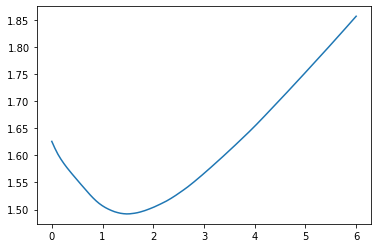

1.491932322847362
1.4773869346733668


In [122]:

plt.plot(parameter,error)
plt.show()

print(np.min(error))
print(parameter[np.argmin(error)])

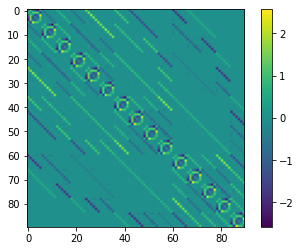

AttributeError: 'NoneType' object has no attribute 'todense'

In [126]:


plt.imshow(h_quibit_tot.todense())
plt.colorbar()
plt.show()

plt.imshow(tot_hamiltonian.setdiag(0).todense())
plt.colorbar()
plt.show()



plt.imshow(tot_hamiltonian.todense()-h_quibit_tot.todense())
plt.colorbar()
plt.show()



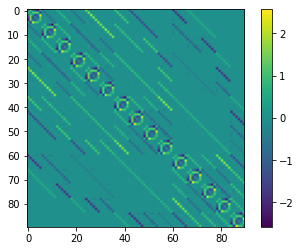

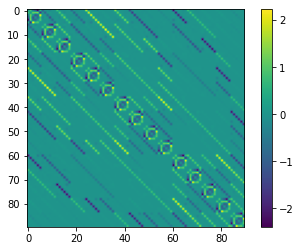

In [128]:
h_quibit_tot.setdiag(0)
tot_hamiltonian.setdiag(0)
plt.imshow(h_quibit_tot.todense())
plt.colorbar()
plt.show()

plt.imshow(tot_hamiltonian.todense())
plt.colorbar()
plt.show()


In [129]:
count=0
for i in range(delta_hamiltonian.shape[0]):
    if delta_hamiltonian[22,i]!=0:
        print(delta_hamiltonian_exact[22,i])
        print(delta_hamiltonian[22,i],'\n')
        count+=1

print(count)

-0.005191703936156058
-0.15572408891824746 

-0.02428782292730855
0.059108666964521404 

-0.021569417309013877
-0.03405480603656366 

0.0052153142439680675
-0.05118650893073746 

-0.05014425276344657
-0.18301085217897797 

-0.002525867802901385
0.03804912096402747 

-0.021580421913935215
-0.1652084182227495 

0.011903449591690375
0.0715405315486859 

0.0078783718269148
0.02360486053356989 

0.011813481007272773
-0.14586446142982465 

-0.10410232373976128
-0.16161377210178884 

0.004474008998604125
0.04253291020680567 

-0.060926069668068294
-2.598063207241043 

0.19462828447549357
1.6647781832344641 

-0.21327131409365993
-1.150477023354693 

-0.08596049608873524
-1.8641898638700451 

-0.8110876076824206
-5.106179198565487 

0.11974559096660191
0.8298342139031927 

0.03643894590376031
0.10525204473881096 

0.009257733772251416
-0.06323688315839802 

0.006673292376202906
0.03804912096402746 

0.013281457939833744
0.04092061211860785 

0.08538139117691178
0.10690789209987217 

-0.0320386

In [130]:
print(psifinal[:,0].conjugate().dot(psiqubit[:,0])*np.conjugate(psifinal[:,0].conjugate().dot(psiqubit[:,0])))

0.9873799884016838


In [119]:
print((psiqubit[:,0].conjugate().dot(tot_hamiltonian.dot(psiqubit[:,0]))))

-87.00528825347885


Analysis with respect to the exact ground state

In [74]:
psiqubit_fermionic=QPC.particles2quasiparticles.T @ psiqubit[:,0]
psifinal_fermionic=QPC.particles2quasiparticles.T @ psifinal[:,0]
fidelity_exact_groundstate=psi0[:,0].conjugate().dot(psiqubit_fermionic)*np.conjugate(psi0[:,0].conjugate().dot(psiqubit_fermionic))
fidelity_exact_groundstate_2=psi0[:,0].conjugate().dot(psifinal_fermionic)*np.conjugate(psi0[:,0].conjugate().dot(psifinal_fermionic))
print(fidelity_exact_groundstate,fidelity_exact_groundstate_2)

0.28173617732415945 0.28665313184583313
